This script treated the PMF model output file, plotted the results of PMF solutions, applied conditional probability function (CPF) analysis (wind rose of PMF factors), and calculated the Ozone formation potential (OFP) of all PMF-solved factors.

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from windrose import WindroseAxes
import matplotlib.cm as cm
import plotly.express as px
import math
import os, importlib, sys

sys.path.append('../../code/src')
#importlib.reload(sys.modules['pmf_result'])
from pmf_result import pmf_output_to_df
from pmf_result import plot_pmf_profile
from pmf_result import plot_factor_time_series
from pmf_result import reorder_factor, plot_CPF

# Plot PMF-solved profile and contribution

In [3]:
# extract PMF output
profile_conc, profile_perc_spec, profile_perc_factor, contribution = \
    pmf_output_to_df(43,9,'../../data/intermediate/PMF_output/Factor9')
new_order = ['Factor 7','Factor 1','Factor 4','Factor 9','Factor 6','Factor 5','Factor 2',
             'Factor 8','Factor 3']
#new_order = ['Factor 1','Factor 5','Factor 2','Factor 8','Factor 4','Factor 3','Factor 7',
#             'Factor 6','Factor 9']
profile_perc_spec = reorder_factor(profile_perc_spec, new_order)
profile_conc = reorder_factor(profile_conc, new_order)
contribution = reorder_factor(contribution, new_order)

# rename factor name in column
factor_name = ['Plant decomposition', 'Biogenic', 'Summer blend gasoline',
               'Winter blend gasoline', 'Institutional refrigerator, air conditioning, cooking', 'Education institution', 'Commercial and industrial solvents', 
               'VCP(siloxane)', 'VCP(EtOH)']
profile_conc.columns = ['Parameter'] + factor_name
contribution.columns = ['Date'] + factor_name

# save files
#profile_conc.to_csv('../../data/final/pmf_profile_conc.csv', index=False)
#contribution.to_csv('../../data/final/pmf_profile_perc_spec.csv', index=False)

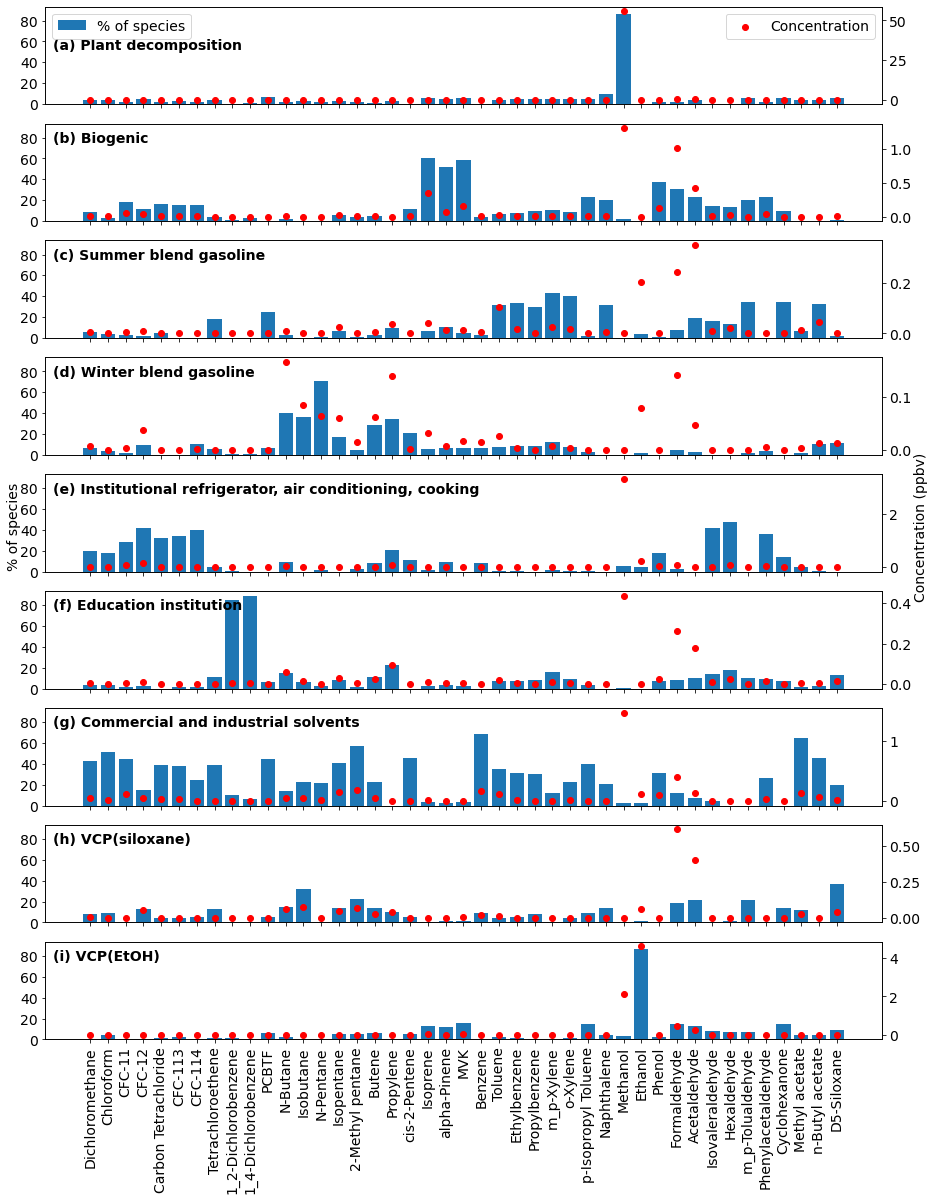

In [4]:
fig = plot_pmf_profile(43,9,profile_perc_spec,profile_conc, factor_name)
fig.savefig('../../result/pmf_profile.png', dpi=1200, bbox_inches='tight')

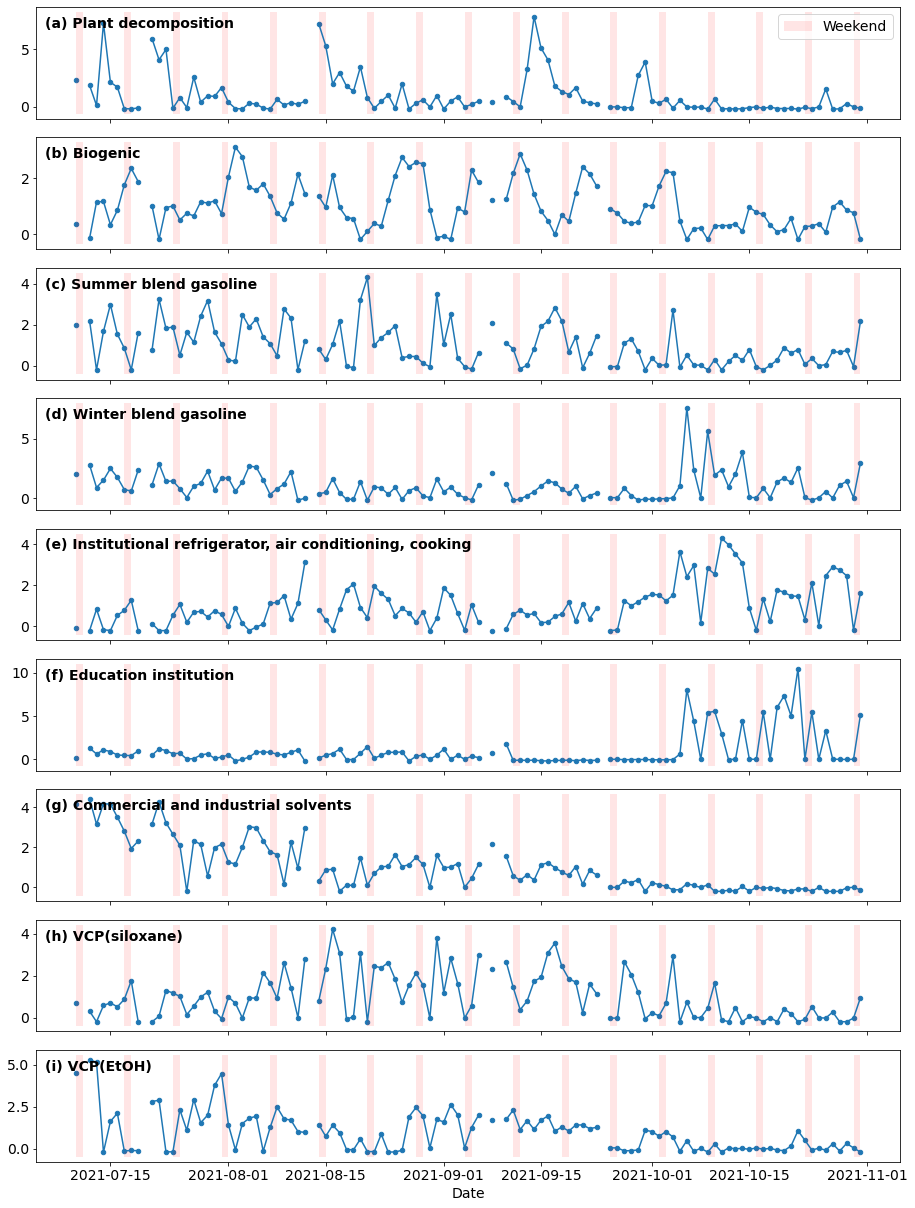

In [5]:
fig = plot_factor_time_series(43,9,contribution, factor_name)
fig.savefig('../../result/pmf_time_series.png', dpi=1200, bbox_inches='tight')

# CPF analysis

In [6]:
# get wind direction and speed file
df_wind_RL = pd.read_csv('../../data/raw/WINSPD_PICKDATA_2021-10-31.csv')
df_wind_RL = df_wind_RL[df_wind_RL['site']=='2077']
df_wind_RL['drct'] = df_wind_RL.value.str.split(pat = '/', expand =True).iloc[:,0]
df_wind_RL['sped'] = df_wind_RL.value.str.split(pat = '/', expand =True).iloc[:,1]
df_wind_RL['drct'] = df_wind_RL['drct'].replace('CALM', np.nan)
df_wind_RL['drct'] = df_wind_RL['drct'].astype(float)
df_wind_RL['sped'] = df_wind_RL['sped'].astype(float)
df_wind_RL['Date'] = pd.to_datetime(df_wind_RL['date'])

# select wind data only in 10AM ~ 12PM
df_wind_filter = df_wind_RL[df_wind_RL['start_hour'].isin([11])]

In [7]:
contribution_wind=contribution.merge(df_wind_filter[['Date','drct', 'sped']], 
                                         on='Date', how='left')

# bin contribution by wind direction
contribution_wind.loc[contribution_wind['drct'].notnull(),'bin']=\
        pd.cut(contribution_wind.loc[contribution_wind['drct'].notnull(),'drct'], np.arange(0,360,30))
df = contribution_wind

# count total events in every factor in every binned wind direction
df_CPF = df.groupby('bin').count().reset_index()
df_CPF_count_total = df_CPF.drop(columns={'Date','drct','sped'})

# count events in upper 25% for every factor in every binned wind direction (df_CPF_count_upper), and count for total events (df_CPF_count_total)
df_CPF_count_upper = df_CPF.drop(columns={'Date','drct','sped'})
for col in df_CPF_count_upper.columns[1:]:
     for bin_val in df['bin'].unique():
        threshold = df.loc[:, col].quantile(0.75)
        count_upper = df[(df['bin']==bin_val)&(df[col]>threshold)].shape[0]
        df_CPF_count_upper.loc[df_CPF_count_upper['bin']==bin_val, col] = count_upper  
            
# calculate mean of bin for windrose plotting
df_CPF_count_upper['bin_mean']=df_CPF_count_upper.bin.apply(lambda x: x.mid)
df_CPF_count_total['bin_mean']=df_CPF_count_total.bin.apply(lambda x: x.mid)
    
# screen out wind direction with total days < 3
df_CPF_count_total = df_CPF_count_total.replace(1,np.nan)
df_CPF_count_total = df_CPF_count_total.replace(2,np.nan)
    
# calculate CPF for each factor
df_ratio = df_CPF_count_upper.iloc[:,1:-1].divide(df_CPF_count_total.iloc[:,1:-1])
df_ratio['bin_mean'] = df_CPF_count_upper['bin_mean']

In [36]:
help(fig.update_polars)

Help on method update_polars in module plotly.graph_objs._figure:

update_polars(patch=None, selector=None, overwrite=False, row=None, col=None, **kwargs) method of plotly.graph_objs._figure.Figure instance
    Perform a property update operation on all polar objects
    that satisfy the specified selection criteria
    
    Parameters
    ----------
    patch: dict
        Dictionary of property updates to be applied to all
        polar objects that satisfy the selection criteria.
    selector: dict, function, or None (default None)
        Dict to use as selection criteria.
        polar objects will be selected if they contain
        properties corresponding to all of the dictionary's keys, with
        values that exactly match the supplied values. If None
        (the default), all polar objects are selected. If a
        function, it must be a function accepting a single argument and
        returning a boolean. The function will be called on each
        polar and those for wh

In [60]:
# plot CPF 
import plotly.express as px
for i in factor_name:  
    fig = px.bar_polar(df_ratio, r=i,
                       theta='bin_mean', range_r=[0, 0.4], 
                       width=100, height=100)
    fig.update_polars(radialaxis=dict(dtick=0.2, visible=True),radialaxis_tickfont_size=10)
    fig.update_polars(angularaxis=dict(dtick=90, visible=True, showticklabels=False))
    fig.update_layout(margin=dict(l=0, r=10, t=0, b=0), title=None)
    fig.show()

    fpath = '../../result/cpf_'+i.replace(' ','-')+'.png'
    fig.write_image(fpath, scale=100)

## Calculate MIR or VOCR of PMF-solved factors

In [61]:
df_reactivity=pd.read_csv('../../data/raw/VOC_reactivity_MIR_redlands.csv')
df_reactivity['Parameter'] = df_reactivity['Parameter'].str.replace(',','_')
df_reactivity.loc[df_reactivity['Parameter'].str.contains('Decamethylcyclopentasiloxane'),'Parameter'] = 'D5-Siloxane'
df_reactivity = df_reactivity.replace('Trichlorofluoromethane','CFC-11')
df_reactivity = df_reactivity.replace('Dichlorodifluoromethane','CFC-12')
df_reactivity = df_reactivity.replace('1_1_2-Trichlorotrifluoroethane','CFC-113')
df_reactivity = df_reactivity.replace('1_2-Dichloro-1_1_2_2-tetrafluoroethane','CFC-114')

# get MIR list
df_MIR = profile_conc.merge(df_reactivity[['Parameter','MW','MIR']], 
                            on='Parameter', how='left')[['Parameter','MW','MIR']]

# get OH reactivity list
df_OH_reactivity = df_reactivity[['Parameter','MW','A','B','E/R(K-1)','Ea(J/mol)','k(T)','T']]

# replace alpha-pinene by TERP concentration used in box model
index_alpha_pinene = profile_conc[profile_conc['Parameter']=='alpha-Pinene'].index[0]
profile_conc.iloc[index_alpha_pinene,1:10] = \
    profile_conc.iloc[index_alpha_pinene,1:10]/0.112459

# calculate MIR for each factor
profile_MIR = profile_conc.merge(df_MIR, on='Parameter', how='left')

# calculate OFP=MIR*[VOC]*MW(VOC)/MW(O3)
for i in profile_MIR.columns[1:10]:
    column_name = 'MIR_' + i
    profile_MIR[column_name] = profile_MIR[i]*profile_MIR['MW']*profile_MIR['MIR']/48
PMF_factor_MIR = profile_MIR.iloc[:,12:]

# sum OFP for each factor
OFP_factor = pd.DataFrame(PMF_factor_MIR.sum(axis=0))
OFP_factor.columns = ['OFP']
OFP_factor['OFP_prec'] = OFP_factor['OFP']/OFP_factor['OFP'].sum()*100

In [64]:
# show the table of OFP
OFP_factor

,OFP,OFP_prec
MIR_Plant decomposition,27.927159,24.266322
MIR_Biogenic,27.068798,23.520479
MIR_Summer blend gasoline,9.135163,7.937678
MIR_Winter blend gasoline,5.661855,4.919669
"MIR_Institutional refrigerator, air conditioning, cooking",6.901117,5.996482
MIR_Education institution,5.942379,5.163421
MIR_Commercial and industrial solvents,8.773234,7.623193
MIR_VCP(siloxane),7.643178,6.641271
MIR_VCP(EtOH),16.033200,13.931485


In [76]:
print(sns.color_palette("pastel").as_hex())
sns.color_palette("pastel")

['#a1c9f4', '#ffb482', '#8de5a1', '#ff9f9b', '#d0bbff', '#debb9b', '#fab0e4', '#cfcfcf', '#fffea3', '#b9f2f0']


[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

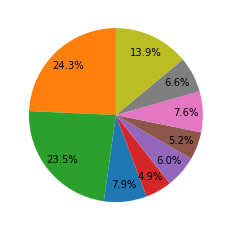

In [85]:
color = ['#ff7f0e','#2ca02c','#1f77b4', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']

plt.rcParams.update({'font.size': 10})
fig, ax=plt.subplots(1)
ax.pie(OFP_factor['OFP_prec'], labels=None, autopct='%.1f%%', pctdistance=0.8,
       shadow=False, startangle=90, textprops={'fontsize': 10}, colors=color)
fig.set_facecolor('white')

fig.savefig('../../result/pie_pmf_OFP.png', dpi=1200, bbox_inches='tight')